#### Import libraries

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score

### Transformation of images

Augmentation, normalization and transformation for train data:

In [4]:
data_transforms = transforms.Compose([
    # Augmentation
    transforms.RandomHorizontalFlip(p=0.3),  
    transforms.RandomRotation(15), 
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1), 
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.1),
    #  transformation
    transforms.ToTensor(),
    # normalization
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

Transformation and normalization for test/split data:

In [5]:
test_val_transforms = transforms.Compose([
    #  transformation
    transforms.ToTensor(),
    # normalization
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

Read images from folders and put them in dataset:

In [6]:
train_dataset = datasets.ImageFolder(root='data/split_dataset/train', transform=data_transforms)
val_dataset = datasets.ImageFolder(root='data/split_dataset/val', transform=test_val_transforms)
test_dataset = datasets.ImageFolder(root='data/split_dataset/test', transform=test_val_transforms)

### Check images 

#### 1) Number of images

In [7]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 4803
    Root location: data/split_dataset/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.3)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
               RandomApply(
               p=0.1
               GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))
           )
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [8]:
print(f"Number of images in the training dataset: {len(train_dataset)}")
print(f"Number of images in the validation dataset: {len(val_dataset)}")
print(f"Number of images in the test dataset: {len(test_dataset)}")

Number of images in the training dataset: 4803
Number of images in the validation dataset: 1029
Number of images in the test dataset: 1030


The number is the same as in "data-preparation-1"

#### 2) Image transformation

lets plot some train image examples:

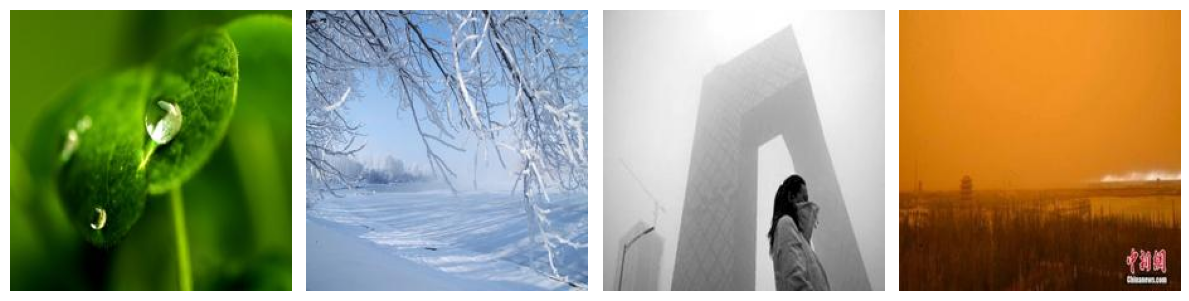

In [9]:
image_paths = [
    "data//split_dataset//train//dew//2208.jpg",   
    "data//split_dataset//train//rime//4931.jpg", 
    "data//split_dataset//train//fogsmog//4075.jpg",
    "data//split_dataset//train//sandstorm//2910.jpg"  
]
plt.figure(figsize=(12, 5))
for i, image_path in enumerate(image_paths):
    img = Image.open(image_path)
    img_size = img.size  
    
    plt.subplot(1, 4, i+1)  
    plt.imshow(img)
    plt.axis('off')  

plt.tight_layout()
plt.show()

Function to get image from tensor form:

In [10]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  
    return tensor

Plot images after transformation:

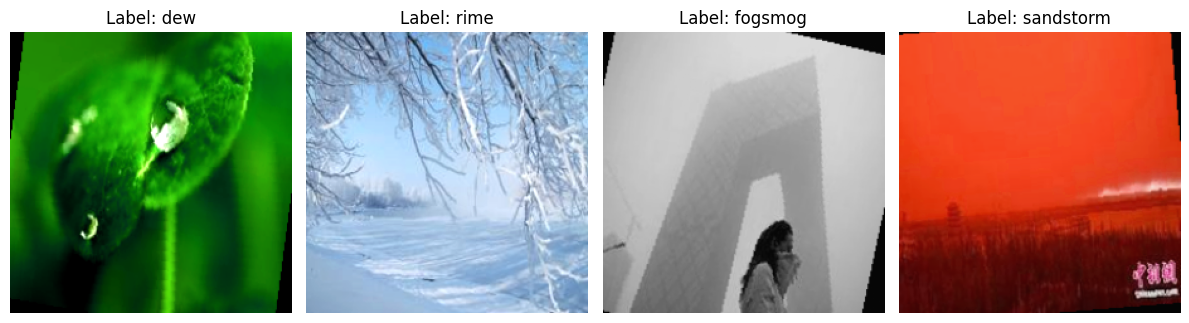

In [11]:
indexes = [0, 3072, 489, 3884]

fig, axes = plt.subplots(1, 4, figsize=(12, 5))

for idx, ax in zip(indexes, axes):
    image, label = train_dataset[idx] 
    image = denormalize(image, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
    npimg = image.numpy().transpose((1, 2, 0)) 
    
    ax.imshow(npimg)
    ax.set_title(f"Label: {train_dataset.classes[label]}")
    ax.axis('off')  

plt.tight_layout()
plt.show()

#### 3) Data loader

In [12]:
batch_size = 64  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
train_loader

### CNN

#### 1) Define structure

Here I define my CNN model: 

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer: 3 input channel (RGB), 32 output channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) 
        # Second convolutional layer: 32 input channel, 64 output channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) 
        # Max pooling layer: 2x2 window, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 56 * 56, 128) 
        
        # len(train_dataset.classes) = 11
        self.fc2 = nn.Linear(128, len(train_dataset.classes))  

    def forward(self, x):
        # conv1 + relu + pooling
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        # conv2 + relu + pooling
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten the tensor
        x = x.reshape(x.shape[0], -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [15]:
model1 = CNN()

Loss fucntion:

In [16]:
criterion = nn.CrossEntropyLoss()

Optimizer:

In [17]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

Learning Rate Scheduler:

In [18]:
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Use device

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

number of epochs

In [20]:
num_epochs = 16

#### 2) Training

In [21]:
def train_model(model, train_loader, val_loader, batch_size, criterion, optimizer, learning_rate, num_epochs, device):

    print()
    print(f"Training with the following configuration:\n"
          f"Learning Rate: {learning_rate}\n"
          f"Batch Size: {batch_size}\n"
          f"Optimizer: {optimizer.__class__.__name__}\n"
          f"Loss Function: {criterion.__class__.__name__}\n"
          f"Number of Epochs: {num_epochs}\n")
    print()
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        # calculate model perfomance
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total    
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
    
        # calculate model perfomance
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
    
        # save model perfomance
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
     #    if scheduler:
     #        scheduler.step()
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [22]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model1, train_loader, val_loader, batch_size, criterion, optimizer, learning_rate, num_epochs, device)


Training with the following configuration:
Learning Rate: 0.001
Batch Size: 64
Optimizer: Adam
Loss Function: CrossEntropyLoss
Number of Epochs: 16


Epoch 1/16, Train Loss: 2.1138, Train Acc: 39.43%, Val Loss: 1.4352, Val Acc: 51.60%
Epoch 2/16, Train Loss: 1.3159, Train Acc: 56.59%, Val Loss: 1.1357, Val Acc: 61.32%
Epoch 3/16, Train Loss: 1.1652, Train Acc: 60.23%, Val Loss: 1.0269, Val Acc: 65.21%
Epoch 4/16, Train Loss: 1.1085, Train Acc: 61.52%, Val Loss: 1.0841, Val Acc: 64.24%
Epoch 5/16, Train Loss: 1.0606, Train Acc: 64.65%, Val Loss: 1.0544, Val Acc: 61.71%
Epoch 6/16, Train Loss: 1.0386, Train Acc: 63.02%, Val Loss: 0.9862, Val Acc: 66.57%
Epoch 7/16, Train Loss: 0.9748, Train Acc: 66.56%, Val Loss: 0.8906, Val Acc: 69.68%
Epoch 8/16, Train Loss: 0.9915, Train Acc: 66.50%, Val Loss: 1.0112, Val Acc: 65.40%
Epoch 9/16, Train Loss: 0.9715, Train Acc: 66.81%, Val Loss: 0.8509, Val Acc: 69.58%
Epoch 10/16, Train Loss: 0.9282, Train Acc: 68.44%, Val Loss: 0.9354, Val Acc: 66.76

As we could see, results are pretty good with 73% val accuracy at the finish. Maybe we could improve results, but for now I would work with these model.

Save trained model1 state and its training data:

In [25]:
#torch.save(model1.state_dict(), 'models\\model1\\model_state_dict.pth')

In [26]:
# torch.save({
#         'train_losses': train_losses,
#         'val_losses': val_losses,
#         'train_accuracies': train_accuracies,
#         'val_accuracies': val_accuracies
#     },  'models\\model1\\training_history.pth')

Upload trained model1:

In [27]:
#model1 = CNN()
#model1.load_state_dict(torch.load('models info\\model_state_dict.pth'))
#model1.eval()

#### 3) Analyze model

Visualize model1 training and validation accuracy:

In [27]:
train_style = {'color': '#373F51', 'linestyle': '-', 'linewidth': 1.5}
val_style = {'color': '#DAA49A', 'linestyle': '-', 'linewidth': 1.5}
train_loss_style = {'color': '#373F51', 'linestyle': '--', 'linewidth': 1.5}
val_loss_style = {'color': '#DAA49A', 'linestyle': '--', 'linewidth': 1.5}

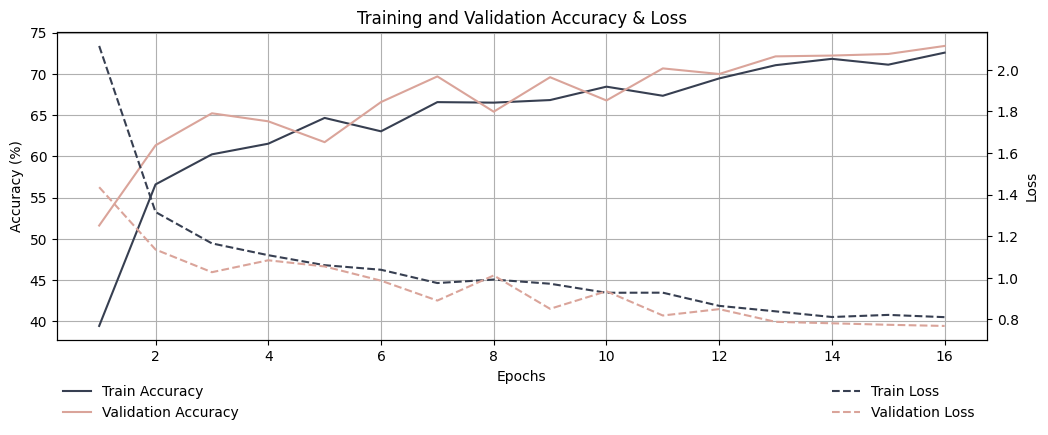

In [28]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', **train_style)
ax1.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', **val_style)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', **train_loss_style)
ax2.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', **val_loss_style)
ax2.set_ylabel('Loss', color='black')
ax2.tick_params(axis='y', labelcolor='black')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

fig.legend(lines_1, labels_1, loc='lower left', bbox_to_anchor=(0.12, -0.12), frameon=False)

fig.legend(lines_2, labels_2, loc='lower right', bbox_to_anchor=(0.9, -0.12), frameon=False)

plt.title('Training and Validation Accuracy & Loss')
plt.show()

To get predicted values:

In [29]:
num_classes = 11

y_true = []
y_pred = []

model1.eval()  
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model1(inputs)
        
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

Plot Confusion matrix:

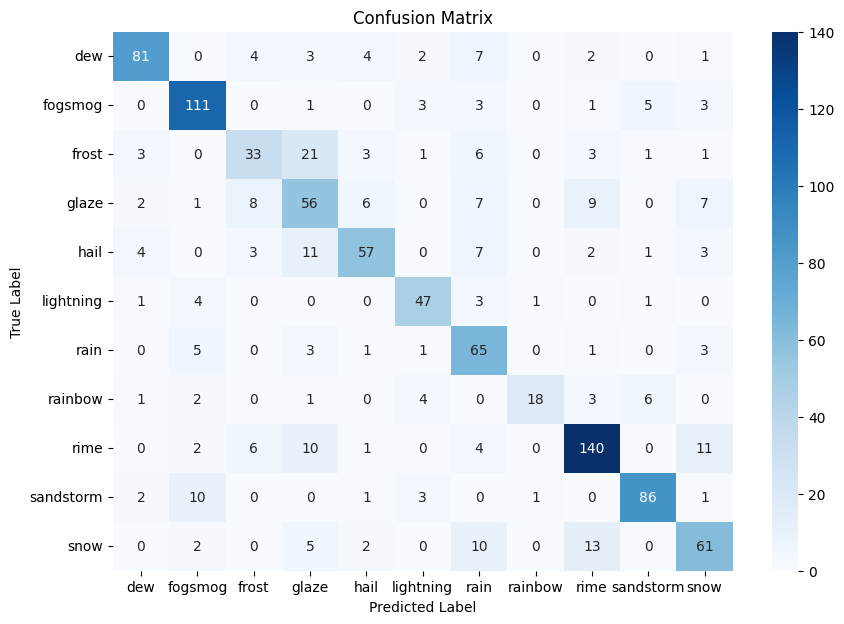

In [30]:
cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

class_names = train_dataset.classes

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Percentage of correct predictions for each class

In [31]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)

for i, acc in enumerate(class_accuracy):
    print(f"{class_names[i]}: {acc * 100:.2f}%")

dew: 77.88%
fogsmog: 87.40%
frost: 45.83%
glaze: 58.33%
hail: 64.77%
lightning: 82.46%
rain: 82.28%
rainbow: 51.43%
rime: 80.46%
sandstorm: 82.69%
snow: 65.59%


So, The worst preditions are for frost and hail. It could be explored later to improve their detection.

In [32]:
precision = precision_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.7394
Accuracy: 0.7337
Recall: 0.7083
F1 Score: 0.7151


Precision, recall, and F1 score are relatively close, indicating that the model's predictions are balanced and reliable.

An accuracy of ~73% shows that the model performs not bad and has learned meaningfull patterns in the data.